In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import ast

In [25]:
pd.set_option('display.width', 200) 

In [ ]:
data = pd.read_csv('../data/exon_classification_with_additional_info.csv')
print(data.head())
print(data.shape)
data["exonlengths"] = data["exonlengths"].apply(ast.literal_eval) #csvを読み込むと数値のリストが文字列のリストとして読み込まれるので、数値のリストに変換

        geneName       name  chrom strand   txStart     txEnd  cdsStart    cdsEnd  exonCount                                         exonStarts                                           exonEnds  \
0  0610005C13Rik  NR_038165   chr7      -  45217218  45224600  45224600  45224600          4           [45217218, 45223836, 45224031, 45224550]           [45217803, 45223946, 45224201, 45224600]   
1  0610005C13Rik  NR_038166   chr7      -  45217218  45224600  45224600  45224600          5  [45217218, 45220409, 45223836, 45224031, 45224...  [45217803, 45220616, 45223946, 45224201, 45224...   
2  0610009B22Rik  NM_025319  chr11      -  51576211  51579461  51576473  51576896          2                               [51576211, 51579374]                               [51576919, 51579461]   
3  0610009E02Rik  NR_152208   chr2      +  26335935  26348007  26348007  26348007          2                               [26335935, 26347684]                               [26336212, 26348007]   
4  0610009

- 全ての遺伝子について、バリアント数の分布を可視化

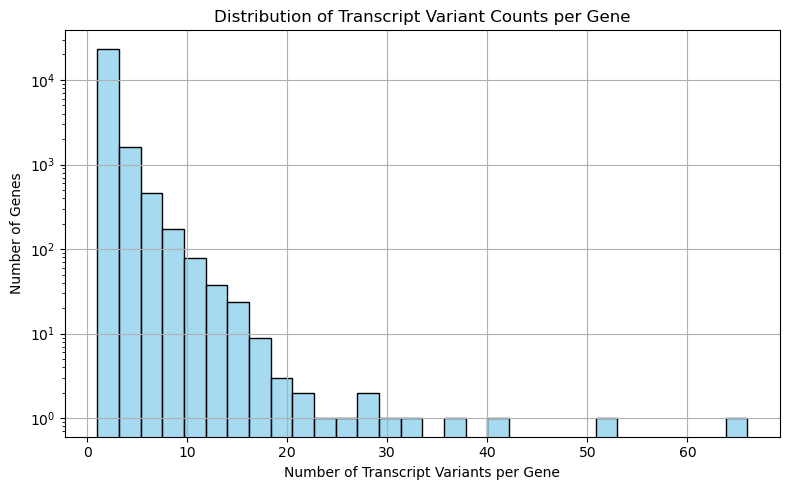

In [55]:
plt.figure(figsize=(8, 5))
variant_counts_per_gene = data.groupby("geneName")["variant_count"].first().values
sns.histplot(variant_counts_per_gene, bins=30, kde=False, color="skyblue")

plt.xlabel("Number of Transcript Variants per Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Transcript Variant Counts per Gene")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()


- 遺伝子当たりの最大or最小エキソン数のヒストグラムを描画する

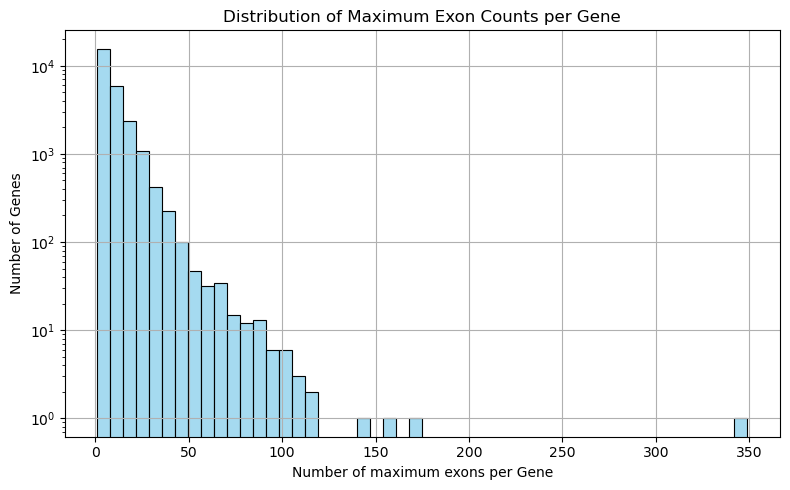

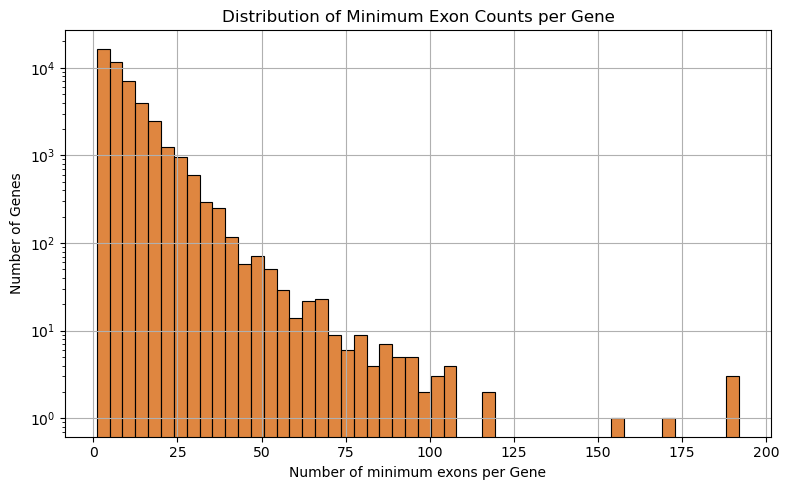

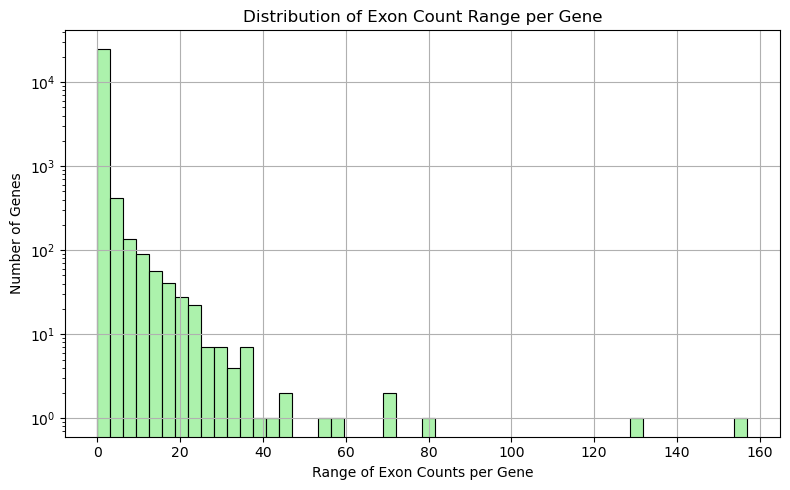

In [52]:
maxcount = data.groupby("geneName")["max_exon_count"].first().values
mincount = data.groupby("geneName")["min_exon_count"].first().values
ange_exon_counts = maxcount - mincount

plt.figure(figsize= (8,5))
sns.histplot(maxcount, bins=50, kde=False, color="skyblue")
plt.xlabel("Number of maximum exons per Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Maximum Exon Counts per Gene")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()

plt.figure(figsize= (8,5))
sns.histplot(data["min_exon_count"], bins=50, kde=False, color="#D55E00")
plt.xlabel("Number of minimum exons per Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Minimum Exon Counts per Gene")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()



plt.figure(figsize=(8, 5))
sns.histplot(range_exon_counts, bins=50, kde=False, color="lightgreen")
plt.xlabel("Range of Exon Counts per Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Exon Count Range per Gene")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()

- エキソン数がtop5の遺伝子の中身を確認する

In [33]:
top_5_exon_counts = data.nlargest(5, "max_exon_count")
print(top_5_exon_counts)

      geneName          name chrom strand   txStart     txEnd  cdsStart    cdsEnd  exonCount                                         exonStarts                                           exonEnds  \
41937      Ttn     NM_011652  chr2      -  76534327  76812891  76535374  76810526        313  [76534327, 76536013, 76536783, 76537040, 76538...  [76535673, 76536316, 76536937, 76537732, 76538...   
41938      Ttn     NM_028004  chr2      -  76534327  76812891  76535374  76810526        192  [76534327, 76536013, 76536783, 76537040, 76538...  [76535673, 76536316, 76536937, 76537732, 76538...   
41939      Ttn  NM_001385708  chr2      -  76534325  76812890  76535374  76810526        349  [76534325, 76536013, 76536783, 76537040, 76538...  [76535673, 76536316, 76536937, 76537732, 76538...   
37384   Snhg14     NR_146211  chr7      -  58922484  60099925  60099925  60099925        172  [58922484, 58926349, 58933773, 58959374, 58967...  [58925012, 58926516, 58933844, 58959474, 58967...   
26665     

- 最大エキソン数 vs バリアント数の散布図を作成するためのdfを作成

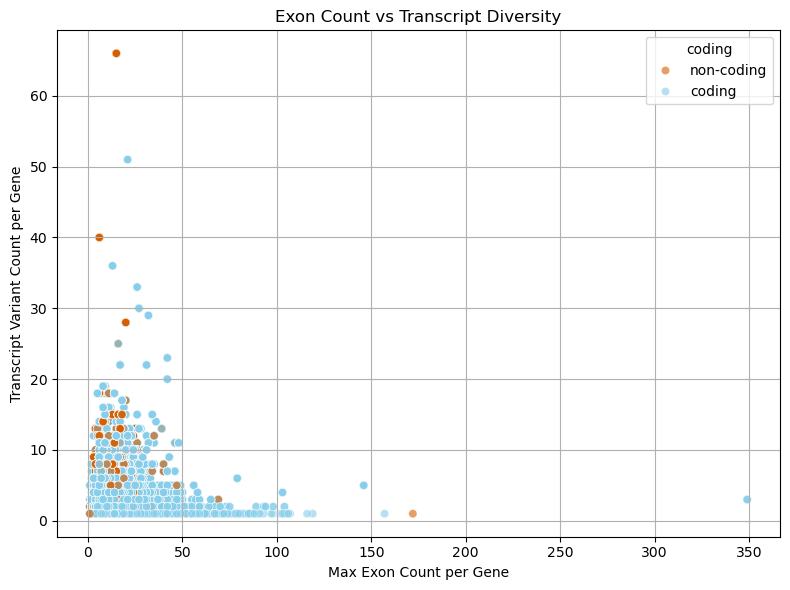

In [34]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data,
    x="max_exon_count",
    y="variant_count",
    alpha=0.6,
    hue="coding",
    palette={"coding": "skyblue", "non-coding": "#D55E00"},
)

plt.xlabel("Max Exon Count per Gene")
plt.ylabel("Transcript Variant Count per Gene")
plt.title("Exon Count vs Transcript Diversity")
plt.grid(True)
plt.tight_layout()
plt.show()


- skipped exon, unique exon, a3ss, a5ss, overlapを持つ遺伝子の数を計算

In [45]:
total_genes = data["geneName"].nunique()
print(f"全遺伝子数: {total_genes}")

# （skipped exon）を持つ遺伝子の数をカウント
genes_have_skipped_exon = data[data["exontype"].str.contains("skipped", na=False)]["geneName"].unique()
print(f"skipped exonを持つ遺伝子数: {len(genes_have_skipped_exon)}")
print(f"skipped exonを持たない遺伝子数: {total_genes - len(genes_have_skipped_exon)}")
print(f"skipped exonを持つ遺伝子の割合: {len(genes_have_skipped_exon) / total_genes:.2%}")

#  （unique exon）を持つ遺伝子の数をカウント
genes_have_unique_exon = data[data["exontype"].str.contains("unique", na=False)]["geneName"].unique()
print(f"unique exonを持つ遺伝子数: {len(genes_have_unique_exon)}")
print(f"unique exonを持たない遺伝子数: {total_genes - len(genes_have_unique_exon)}")
print(f"unique exonを持つ遺伝子の割合: {len(genes_have_unique_exon) / total_genes:.2%}")

# 少なくとも（skipped exon）と（unique exon）のいずれかを持つ遺伝子の数をカウント
genes_have_skipped_or_unique_exon = data[
    data["exontype"].str.contains("skipped|unique", na=False)]["geneName"].unique()
print(f"skipped exonまたはunique exonを持つ遺伝子数: {len(genes_have_skipped_or_unique_exon)}")
print(f"skipped exonとunique exonの両方を持たない遺伝子数: {total_genes - len(genes_have_skipped_or_unique_exon)}")
print(f"skipped exonまたはunique exonを持つ遺伝子の割合: {len(genes_have_skipped_or_unique_exon) / total_genes:.2%}")

# (a3ss alternative 3' splice site)を持つ遺伝子の数をカウント
genes_have_a3ss = data[data["exontype"].str.contains("a3ss", na=False)]["geneName"].unique()
print(f"a3ss alternative 3' splice siteを持つ遺伝子数: {len(genes_have_a3ss)}")
print(f"a3ss alternative 3' splice siteを持たない遺伝子数: {total_genes - len(genes_have_a3ss)}")
print(f"a3ss alternative 3' splice siteを持つ遺伝子の割合: {len(genes_have_a3ss) / total_genes:.2%}")

# (a5ss alternative 5' splice site)を持つ遺伝子の数をカウント
genes_have_a5ss = data[data["exontype"].str.contains("a5ss", na=False)]["geneName"].unique()
print(f"a5ss alternative 5' splice siteを持つ遺伝子数: {len(genes_have_a5ss)}")
print(f"a5ss alternative 5' splice siteを持たない遺伝子数: {total_genes - len(genes_have_a5ss)}")
print(f"a5ss alternative 5' splice siteを持つ遺伝子の割合: {len(genes_have_a5ss) / total_genes:.2%}")

# overlapping exonを持つ遺伝子の数をカウント
genes_have_overlapping_exon = data[data["exontype"].str.contains("overlap", na=False)]["geneName"].unique()
print(f"overlapping exonを持つ遺伝子数: {len(genes_have_overlapping_exon)}")
print(f"overlapping exonを持たない遺伝子数: {total_genes - len(genes_have_overlapping_exon)}")
print(f"overlapping exonを持つ遺伝子の割合: {len(genes_have_overlapping_exon) / total_genes:.2%}")

# split exonを持つ遺伝子の数をカウント
genes_have_split_exon = data[data["exontype"].str.contains("split", na=False)]["geneName"].unique()
print(f"split exonを持つ遺伝子数: {len(genes_have_split_exon)}")
print(f"split exonを持たない遺伝子数: {total_genes - len(genes_have_split_exon)}")
print(f"split exonを持つ遺伝子の割合: {len(genes_have_split_exon) / total_genes:.2%}")

# outflame exonを持つ遺伝子の数をカウント
genes_have_outflame_exon = data[data["flame"].str.contains("out-flame", na=False)]["geneName"].unique()
print(f"outflame exonを持つ遺伝子数: {len(genes_have_outflame_exon)}")
print(f"outflame exonを持たない遺伝子数: {total_genes - len(genes_have_outflame_exon)}")
print(f"outflame exonを持つ遺伝子の割合: {len(genes_have_outflame_exon) / total_genes:.2%}")


全遺伝子数: 25731
skipped exonを持つ遺伝子数: 3013
skipped exonを持たない遺伝子数: 22718
skipped exonを持つ遺伝子の割合: 11.71%
unique exonを持つ遺伝子数: 5654
unique exonを持たない遺伝子数: 20077
unique exonを持つ遺伝子の割合: 21.97%
skipped exonまたはunique exonを持つ遺伝子数: 6698
skipped exonとunique exonの両方を持たない遺伝子数: 19033
skipped exonまたはunique exonを持つ遺伝子の割合: 26.03%
a3ss alternative 3' splice siteを持つ遺伝子数: 3903
a3ss alternative 3' splice siteを持たない遺伝子数: 21828
a3ss alternative 3' splice siteを持つ遺伝子の割合: 15.17%
a5ss alternative 5' splice siteを持つ遺伝子数: 3447
a5ss alternative 5' splice siteを持たない遺伝子数: 22284
a5ss alternative 5' splice siteを持つ遺伝子の割合: 13.40%
overlapping exonを持つ遺伝子数: 559
overlapping exonを持たない遺伝子数: 25172
overlapping exonを持つ遺伝子の割合: 2.17%
split exonを持つ遺伝子数: 779
split exonを持たない遺伝子数: 24952
split exonを持つ遺伝子の割合: 3.03%
outflame exonを持つ遺伝子数: 23400
outflame exonを持たない遺伝子数: 2331
outflame exonを持つ遺伝子の割合: 90.94%


- 全遺伝子ではなく、skipped exonが生じうる可能性のある条件を満たすエキソンだけを分母としてみる

In [36]:
# 最大エキソンが1つの遺伝子をカウント
genes_with_one_exon = data[data["max_exon_count"] == 1]["geneName"].unique()
print(f"最大エキソンが1つの遺伝子数: {len(genes_with_one_exon)}")
# transcript variantsが1つの遺伝子をカウント
genes_with_one_variant = data[data["variant_count"] == 1]["geneName"].unique()  
print(f"transcript variantsが1つの遺伝子数: {len(genes_with_one_variant)}")

# エキソンが一つまたはtranscript variantsが一つの遺伝子をカウント
genes_with_one_exon_or_one_variant = data[
    (data["max_exon_count"] == 1) | (data["variant_count"] == 1)
]["geneName"].unique()
print(f"最大エキソンが一つまたはtranscript variantsが一つの遺伝子数: {len(genes_with_one_exon_or_one_variant)}")

# skipped exon or unique exonをもつ遺伝子をカウント
genes_have_skipped_or_unique_exon = data[
    data["exontype"].str.contains("skipped|unique", na=False)]["geneName"].unique()

# total genes数をカウント
total_genes = data["geneName"].nunique()
print(f"全遺伝子数: {total_genes}")

# skipped exonまたはunique exonが生じうる遺伝子を母数にしてSkipped exonを持つ遺伝子の割合を計算
print(f"skipped exonを持つ遺伝子の割合 (skipped exonまたはunique exonが生じうる遺伝子を母数とする): "
    f"{len(genes_have_skipped_or_unique_exon) / ((total_genes)-len(genes_with_one_exon_or_one_variant)):.2%}")

# 最大exonが一つまたはtranscript variantsが一つの遺伝子でskipped exonまたはunique exonを持つ遺伝子
genes_with_one_exon_or_one_variant_and_skipped_or_unique = data[
    (data["geneName"].isin(genes_with_one_exon_or_one_variant)) &
    (data["exontype"].str.contains("skipped|unique", na=False))
]
print(f"最大エキソンが一つまたはtranscript variantsが一つの遺伝子でskipped exonまたはunique exonを持つ遺伝子数: "
    f"{len(genes_with_one_exon_or_one_variant_and_skipped_or_unique)}")

最大エキソンが1つの遺伝子数: 3726
transcript variantsが1つの遺伝子数: 16913
最大エキソンが一つまたはtranscript variantsが一つの遺伝子数: 16923
全遺伝子数: 25731
skipped exonを持つ遺伝子の割合 (skipped exonまたはunique exonが生じうる遺伝子を母数): 76.04%
最大エキソンが一つまたはtranscript variantsが一つの遺伝子でskipped exonまたはunique exonを持つ遺伝子数: 0


- 分割されたエキソンの例

In [56]:
print(data[data["geneName"] == "1600012H06Rik"].head(10))
#unique ではなく　splitと表示されていることを確認


         geneName          name  chrom strand   txStart     txEnd  cdsStart    cdsEnd  exonCount            exonStarts              exonEnds  exonlengths  \
93  1600012H06Rik  NM_001083880  chr17      +  15163445  15166201  15163874  15164432          2  [15163445, 15163833]  [15163581, 15166201]  [136, 2368]   
94  1600012H06Rik  NM_001083881  chr17      +  15163445  15166201  15163874  15164432          2  [15163445, 15163763]  [15163581, 15166201]  [136, 2438]   
95  1600012H06Rik  NM_001083882  chr17      +  15163445  15166201  15163874  15164432          1            [15163445]            [15166201]       [2756]   
96  1600012H06Rik     NM_026451  chr17      +  15163445  15166201  15163874  15164432          2  [15163445, 15163828]  [15163581, 15166201]  [136, 2373]   

                                           exons          exontype  coding                       flame  max_exon_count  min_exon_count  variant_count  
93  [(15163445, 15163581), (15163833, 15166201)]  ['a5ss', 'a3

In [44]:
print(data.head(5))

        geneName       name  chrom strand   txStart     txEnd  cdsStart    cdsEnd  exonCount                                         exonStarts                                           exonEnds  \
0  0610005C13Rik  NR_038165   chr7      -  45217218  45224600  45224600  45224600          4           [45217218, 45223836, 45224031, 45224550]           [45217803, 45223946, 45224201, 45224600]   
1  0610005C13Rik  NR_038166   chr7      -  45217218  45224600  45224600  45224600          5  [45217218, 45220409, 45223836, 45224031, 45224...  [45217803, 45220616, 45223946, 45224201, 45224...   
2  0610009B22Rik  NM_025319  chr11      -  51576211  51579461  51576473  51576896          2                               [51576211, 51579374]                               [51576919, 51579461]   
3  0610009E02Rik  NR_152208   chr2      +  26335935  26348007  26348007  26348007          2                               [26335935, 26347684]                               [26336212, 26348007]   
4  0610009